<a href="https://colab.research.google.com/github/FabriceBeaumont/4216_Biomedical_DS_and_AI/blob/main/Sheet9/Assignment9_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

import tensorflow as tf

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tensorflow import keras
from tensorflow.keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, train_test_split
from sklearn.calibration import calibration_curve

In [192]:
def get_dataset_from_github(filename, index_col_str=None, header_str='infer'):    
    data_file_path = "https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/tree/main/Datasets"
    if index_col_str is None and header_str == 'infer':
      data = pd.read_csv(data_file_path + filename)
    elif index_col_str is None:
        data = pd.read_csv(data_file_path + filename, header=header_str)
    elif header_str == 'infer':
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str)
    else:
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str, header=header_str)

    return data

## Biomedical Data Science & AI

## Assignment 9

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - Basics of NN

From the MNIST database load the handwritten digits dataset.

In [193]:
# Load the data: 
# Split between train and test sets w.r.t. data 'x' and class vectors 'y'
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#### 1.1. Normalize your dataset before training your model.

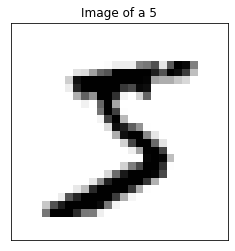

In [194]:
# For normalization we scale the images to contain values in [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Alternative approach:
# x_train = tf.keras.utils.normalize(x_train, axis=1)

# Print the first image to get an idea of the data
index = 0
_classification = y_train[0]
plt.imshow(x_train[0], cmap=plt.cm.binary); plt.title(f"Image of a {_classification}")
plt.xticks([]); plt.yticks([]); plt.show()

In [195]:
# Check, that all images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
input_shape = x_train[0].shape

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [196]:
# Check, if the number of classes is ten (since there are ten digits 0,...,9)
num_classes = 10

if num_classes == len(set(y_train)) == len(set(y_test)): print(f"There are {num_classes} classes.")

There are 10 classes.


#### 1.2. Train a neural network once using **Adam** and once using **AdaGrad** optimizer. 

*Hint*: Set epochs to $20$, neurons of hidden layer to $100$ and use the ReLU as activation function.

In [197]:
num_epochs = 20
num_hidden_neurons = 100
activation_fct = "relu"
# Alternative: 
# activation_fct = tf.nn.relu

loss = "sparse_categorical_crossentropy"

In [198]:
model = keras.Sequential(
    [
        # Input layer   (size 28x28 -> 784)
        keras.Input(shape=input_shape),
        layers.Flatten(),
     
        # One hidden layer  (size 'num_hidden_neurons'=100)
        layers.Dense(num_hidden_neurons, activation=activation_fct),

        # Output layer  (size 10)
        # Use 'softmax' to get a probability for the digits 0,...,9 as classification
        layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [199]:
# Compile the model with 'adam'
model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])

# Train the model
# Also pass the validation data, because this way the history will contain
# the loss and accuracy w.r.t. to the validation data too (for later use)
history_adam = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Save the score (validation loss and validation accuracy) for later use
score_adam = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2755 - accuracy: 0.9235 - val_loss: 0.1453 - val_accuracy: 0.9567
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1244 - accuracy: 0.9631 - val_loss: 0.1012 - val_accuracy: 0.9695
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0867 - accuracy: 0.9744 - val_loss: 0.0859 - val_accuracy: 0.9734
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0668 - accuracy: 0.9797 - val_loss: 0.0823 - val_accuracy: 0.9742
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0526 - accuracy: 0.9836 - val_loss: 0.0793 - val_accuracy: 0.9744
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0421 - accuracy: 0.9871 - val_loss: 0.0748 - val_accuracy: 0.9769
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0345 - accuracy: 0.9898 - val_loss: 0.0722 - val_accuracy:

In [200]:
# Now do the same using AdaGrad. First compile the model
model.compile(loss=loss, optimizer="adagrad", metrics=["accuracy"])

# Train the model
history_adagrad = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Save the score (validation loss and validation accuracy) for later use
score_adagrad = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0997 - val_accuracy: 0.9766
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0980 - val_accuracy: 0.9767
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0969 - val_accuracy: 0.9769
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0961 - val_accuracy: 0.9771
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0955 - val_accuracy: 0.9774
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0950 - val_accuracy: 0.9777
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0945 - val_accuracy:

In [201]:
# Compare the scores of the two models
print(f'ADAM:    Validation loss: {score_adam[0]:.2f},\tValidation accuracy: {score_adam[1]:.2f} %')
print(f'ADAGRAD: Validation loss: {score_adagrad[0]:.2f},\tValidation accuracy: {score_adagrad[1]:.2f} %')

ADAM:    Validation loss: 0.10,	Validation accuracy: 0.98 %
ADAGRAD: Validation loss: 0.09,	Validation accuracy: 0.98 %


#### 1.3. Plot the *SparseCategoricalCrossentropy* loss for both models. Plot the computed accuracy for both models. Which model performed better while training?

In [202]:
history_adam.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

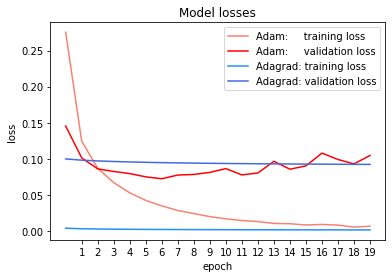

In [203]:
# Now plot the losses
plt.plot(history_adam.history['loss'], c="salmon")
plt.plot(history_adam.history['val_loss'], c="red")

plt.plot(history_adagrad.history['loss'], c="dodgerblue")
plt.plot(history_adagrad.history['val_loss'], c="royalblue")

plt.title('Model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(1, num_epochs))
plt.legend(['Adam:     training loss', 'Adam:     validation loss', 'Adagrad: training loss', 'Adagrad: validation loss'])
plt.show()

#### 1.4. Compute the model accuracy on the test set for both optimizers. Which model performed better?

In [204]:
print(f"The model using ADAM    reached an accuracy of {score_adam[1]:.2f} %")
print(f"The model using ADAGRAD reached an accuracy of {score_adagrad[1]:.2f} %")
print(f"Thus the model using ADAGRAD performed better.")

The model using ADAM    reached an accuracy of 0.98 %
The model using ADAGRAD reached an accuracy of 0.98 %
Thus the model using ADAGRAD performed better.


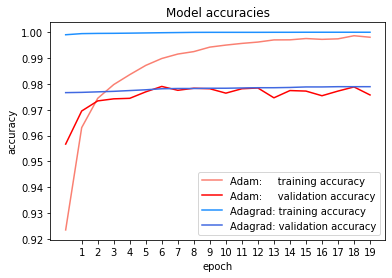

In [205]:
# Plot the accuracies
plt.plot(history_adam.history['accuracy'], c="salmon")
plt.plot(history_adam.history['val_accuracy'], c="red")

plt.plot(history_adagrad.history['accuracy'], c="dodgerblue")
plt.plot(history_adagrad.history['val_accuracy'], c="royalblue")

plt.title('Model accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(1, num_epochs))
plt.legend(['Adam:     training accuracy', 'Adam:     validation accuracy', 'Adagrad: training accuracy', 'Adagrad: validation accuracy'])
plt.show()

#### 1.5. Familiarize yourself with **Layer Normalization** and explain how it works.

**Layer normalization** is the process of normalizing the activations of layers *for each given example* in a batch *independently*. 

Thus it is similar to batch normalization, but does not have the same limitations. Limitations of batch normalization that layer normalization does not have are:
- normalization accross a batch and thus dependent of the other examples in the batch
- no obvious application to *recurrent NN* (*RNN*): The summed inputs often vary with the length of the sequence!
- no application to online learning algorithms

Furthermore, unlike batch normalization, layer
normalization performs exactly the same computation at training and *validation*.

Important **benefits** of batch normalization are also given by layer normalization:
- stabilizes the hidden state dynamics in recurrent networks
- can substantially reduce the training time

##### Mathematical description of layer normalization:

Let 
- $a^l$ be the vector representation of the summed inputs to the neurons in layer $l$,
- $W^l$ be the weights between layer $l-1$ and $l$,
- $x^l$ the inputs for layer $l$,
- $b^l$ the bias of layer $l$ and
- $f$ activation function.

It is
$$ a_i^l = {w_i^l}^\intercal x^l ,\qquad\qquad x_i^{l+1} =f\big( a_i^l + b_i^l \big) $$

For layer normalization, adjust the mean and variance of every layer to be the mean and variance over *all hidden units in the same layer*. Let $l$ be a layer with $H$ neurons. Define
$$ \mu^l := \frac{1}{H} \sum_{i=1}^{H} a_i^l,\qquad\qquad \sigma^l := \sqrt{ \frac{1}{H} \sum_{i=1}^{H} (a_i^l-\mu^l)^2 } $$

Source:
- ["Layer Normalization"](https://arxiv.org/pdf/1607.06450v1) by Jimmy Lei Ba, Jamie Ryan Kiros, Geoffrey E. Hinton, 2016

#### 1.6. Use the same dataset to train a neural network with Layer Normalization.

In [206]:
model = keras.Sequential(
    [
        # Input layer   (size 28x28 -> 784)
        keras.Input(shape=input_shape),
        layers.Flatten(),
        # TODO: since the input was originally normalized, if this necessary here too?
        layers.LayerNormalization(axis=1),
     
        # One hidden layer  (size 'num_hidden_neurons'=100)
        layers.Dense(num_hidden_neurons, activation=activation_fct),
        layers.LayerNormalization(axis=1),

        # Output layer  (size 10)
        # Use 'softmax' to get a probability for the digits 0,...,9 as classification
        layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
layer_normalization_5 (Layer (None, 784)               1568      
_________________________________________________________________
dense_32 (Dense)             (None, 100)               78500     
_________________________________________________________________
layer_normalization_6 (Layer (None, 100)               200       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                1010      
Total params: 81,278
Trainable params: 81,278
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Lets use AdaGrad, since it performed better. First compile the model
model.compile(loss=loss, optimizer="adagrad", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Save the score (validation loss and validation accuracy) for later use
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6480 - accuracy: 0.8131 - val_loss: 0.3993 - val_accuracy: 0.8891
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3691 - accuracy: 0.8979 - val_loss: 0.3243 - val_accuracy: 0.9099
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3143 - accuracy: 0.9129 - val_loss: 0.2889 - val_accuracy: 0.9197
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2836 - accuracy: 0.9219 - val_loss: 0.2674 - val_accuracy: 0.9236
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2628 - accuracy: 0.9272 - val_loss: 0.2511 - val_accuracy: 0.9280
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2470 - accuracy: 0.9313 - val_loss: 0.2391 - val_accuracy: 0.9311
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2345 - accuracy: 0.9348 - val_loss: 0.2287 - val_accuracy:

##### 1.6.a. Compute the SparseCategoricalCrossentropy loss and model accuracy.

In [208]:
print(f'ADAGRAD with layer normlization:\nValidation loss: {score[0]:.2f},\tValidation accuracy: {score[1]:.2f} %')

ADAGRAD with layer normlization:
Validation loss: 0.17,	Validation accuracy: 0.95 %


##### 1.6.b. Evaluate the model performance using the test dataset.

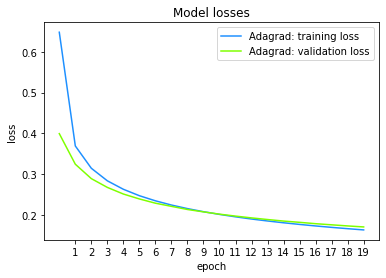

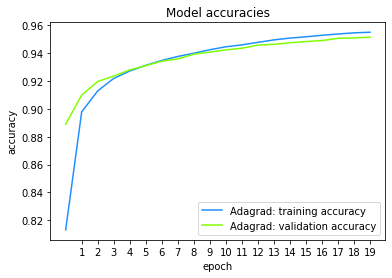

In [215]:
singular = ['loss', 'accuracy']
plural = ['losses', 'accuracies']

for i in range(len(singular)):
    mode = singular[i]

    plt.plot(history.history[mode], c="dodgerblue")
    plt.plot(history.history[f"val_{mode}"], c="chartreuse")

    plt.title(f"Model {plural[i]}")
    plt.ylabel(mode)
    plt.xlabel('epoch')
    plt.xticks(range(1, num_epochs))
    plt.legend([f"Adagrad: training {mode}", f"Adagrad: validation {mode}"])
    plt.show()

Just from looking at the plots we can see that the training went as desired: The loss steadily decreased while the accuracy increased.

Interestingly, the to be expected relation that the loss on the validation set is higher and the accuracy lower than on the training set is only the case after already 5 and 10 epochs.

We can see that around epoch 10, the loss on the training data gets lower, than on the validation loss. But the loss on the validation data still decreases, thus one can continue the training.

---
### Exercise 2 - Hyper Parameter Optimization

#### 2.1. What are the main challenges with hyper-parameter optimization for neural networks?

##### 2.2. Inform yourself about variants of **Bayesian-HPO** and explain them in detail.

#### 2.3. Using the same MNIST dataset, optimize the activation function for the output layer and the number of dropout units in the NN model using the following methods.

In [210]:
###### For preparation do the same as in exercise 1.1.: ######
# Load the data: 
# Split between train and test sets w.r.t. data 'x' and class vectors 'y'
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# For normalization we scale the images to contain values in [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Check, that all images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
input_shape = x_train[0].shape

# Check, if the number of classes is ten (since there are ten digits 0,...,9)
num_classes = 10

num_classes == len(set(y_train)) == len(set(y_test))

# Convert the class vectors 'y' to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

##### 2.3.a. Grid search

##### 2.3.a. Random search

##### 2.3.a. Bayesian Hyper-parameter optimization

---
### Exercise 3 - Transfer Learning & CNNs

#### 3.1. Load the *VGG16 pre-trained model* using Keras Applications API. Use the model to classify the dog images in canines.zip after pre-processing each image by doing the following:

(*See [MachineLearningMastery](ttps://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/) for reference*)

In [211]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img

In [212]:
model = VGG16()
# plot_model(model, to_file='vgg.png')

553476096/553467096 [==============================] - 3s 0us/step


##### 3.1.a. Load each image and set the size to 224 x 224 pixels.

In [213]:
image_target_size = (224, 224)

##### 3.1.b. Convert the image pixels to a numpy array and reshape it according to the model’s input requirements.

##### 3.1.c. Use the model to print out the predicted class and its probability for each image.

#### 3.2. Downscale the given matrix by applying the following pooling operations:

##### 3.2.a. Max Pool

##### 3.2.a. Average Pool

#### 3.3. Load the **CIFAR10 dataset** using Keras datasets API and normalize the images’ pixel values. Train a convolutional neural network to classify the dataset images with the following architecture:

##### 3.3.a. Convolutional Base:
1. An input convolution layer with $32$ filters and a kernel size of $(3,3)$.
Adjust your input shape to that of the CIFAR images’ format
2. Two convolution layers, each with 64 filters and a kernel size of $(3,3)$
3. Two Max Pool layers, with a pool size of $2\times 2$

##### 3.3.b. Two dense layers, with $64$ and $10$ units respectively. Adjust the output of the convolutional base such that it satisfies the input requirements of the dense layers.

##### 3.3.c. Use the following parameters to train the network:
1. Sparse categorical cross entropy as your loss function
1. Adam optimizer
1. $10$ epochs
1. ReLU activation for your layers

Compile your model, then plot the accuracy across each epoch.